# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [41]:
import os

print(os.listdir('../input/the-nature-conservancy-fisheries-monitoring'))

['train', 'sample_submission_stg1.csv', 'test_stg1']


In [42]:
%matplotlib inline
import cv2
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Загружаем разметку

In [43]:
import os
import json
from glob import glob

# TODO: скачайте данные и сохраните в директорию:
TRAIN_PREFIX = '../input/the-nature-conservancy-fisheries-monitoring/train'

def load_boxes():
    boxes = dict()
    
    for path in glob('../input/boxes-labels/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            boxes[label] = json.load(src)
            for annotation in boxes[label]:
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
            for annotation in boxes[label]:
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation['annotations'], scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [44]:
boxes = load_boxes()  # разметка детекций

In [45]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()],
             columns=['class', 'count'])

,class,count
0,lag,67
1,alb,1719
2,bet,200
3,yft,734
4,shark,176
5,dol,117


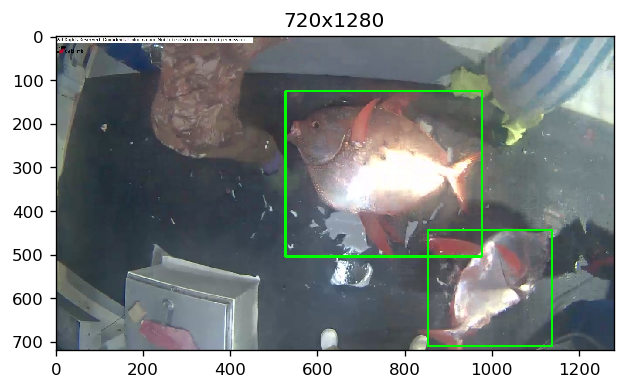

In [46]:
plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(boxes['lag'][17])
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

### Распределение размеров разметки

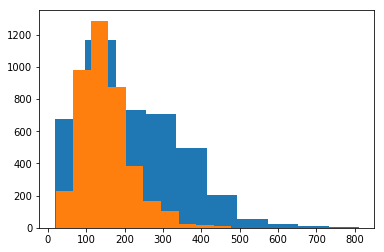

In [47]:
annotations = sum([box['annotations']
                  for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [48]:
IMG_HEIGHT = 270
IMG_WIDTH = 480

features = keras.applications.vgg16.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

feature_tensor = features.layers[-1].output

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

# Сетка якорей (anchor grid)

In [49]:
FEATURE_SHAPE = (feature_tensor.shape[1].value,
                 feature_tensor.shape[2].value)

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [50]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh]
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

### Валидация енкодинга/декодинга

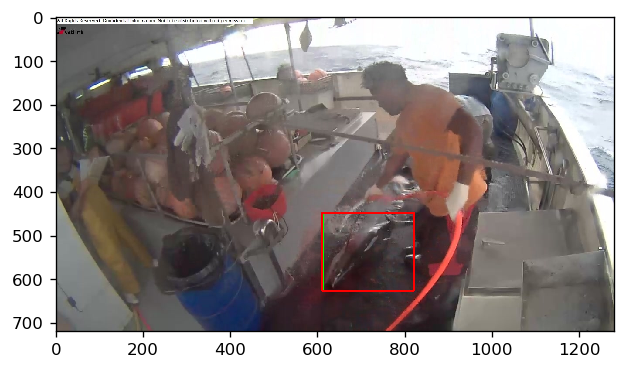

In [51]:
example = boxes['alb'][15]

encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH))

decoded = decode_prediction(encoded, conf_thr=0.5)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(example, decoded[:10]))

## Функция потерь

In [52]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def class_loss(y_true, y_pred):
    y_true = K.reshape(y_true[1], (-1, 6))
    y_pred = K.reshape(y_pred[1], (-1, 6))
    class_loss = K.categorical_crossentropy(y_true, y_pred, from_logits=True)
    return class_loss

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true[0])[0]
    
    y_true = K.reshape(y_true[0], (batch_size, -1, 5))
    y_pred = K.reshape(y_pred[0], (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss

## Загрузка данных

In [53]:
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
TRAIN_DIR = '../input/the-nature-conservancy-fisheries-monitoring/train/'
ROWS = 270
COLS = 480
CHANNELS = 3

def get_images(fish):
    fish_dir = TRAIN_DIR+'{}'.format(fish)
    images = [fish+'/'+im for im in os.listdir(fish_dir)]
    return images

def read_image(src):
    im = cv2.imread(src, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (COLS, ROWS), interpolation=cv2.INTER_CUBIC)
    return im


files = []
y_all = []

for fish in FISH_CLASSES:
    fish_files = get_images(fish)
    files.extend(fish_files)
    
    y_fish = np.tile(fish, len(fish_files))
    y_all.extend(y_fish)
    print("{0} photos of {1}".format(len(fish_files), fish))
    
y_all = np.array(y_all)

1719 photos of ALB
200 photos of BET
117 photos of DOL
67 photos of LAG
465 photos of NoF
299 photos of OTHER
176 photos of SHARK
734 photos of YFT


In [54]:
X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, im in enumerate(files): 
    X_all[i] = read_image(TRAIN_DIR+im)
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

print(X_all.shape)

Processed 0 of 3777
Processed 1000 of 3777
Processed 2000 of 3777
Processed 3000 of 3777
(3777, 270, 480, 3)


In [55]:
# One Hot Encoding Labels
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

y_all = LabelEncoder().fit_transform(y_all)
y_all = np_utils.to_categorical(y_all)

## Добавляем выход детектора

In [56]:
output = keras.layers.BatchNormalization()(feature_tensor)
from keras.regularizers import l2

x = keras.layers.Flatten()(output)

x = keras.layers.Dense(256, activation='relu', name='dense_one')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu', name='dense_two')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation='relu', name='dense_three')(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(8, activation='sigmoid', kernel_regularizer=keras.regularizers.l1(1e-4), name='output')(x)

model = keras.models.Model(inputs=features.inputs, outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 270, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 270, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 270, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 135, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 135, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 135, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 67, 120, 128)      0   

## Обучение

In [57]:
adam = keras.optimizers.Adam(lr=3e-4, decay=1e-6)
#model.compile(optimizer=adam, 
#              loss=total_loss,
#              metrics={'dense_1': confidence_loss})

model.compile(loss='categorical_crossentropy', optimizer=adam)

In [58]:
model.fit(X_all, y_all, batch_size=64, nb_epoch=3,
              validation_split=0.2, verbose=1, shuffle=True)

Train on 3021 samples, validate on 756 samples
Epoch 1/3
3021/3021 [==============================] - 30s 10ms/sample - loss: 2.0741 - val_loss: 1.8844
Epoch 2/3
3021/3021 [==============================] - 28s 9ms/sample - loss: 1.9078 - val_loss: 1.9429
Epoch 3/3
3021/3021 [==============================] - 28s 9ms/sample - loss: 1.8105 - val_loss: 2.2155


In [59]:
model.save('model.hdf5')

In [60]:
TEST_DIR = '../input/the-nature-conservancy-fisheries-monitoring/test_stg1/'


test_files = [im for im in os.listdir(TEST_DIR)]
test = np.ndarray((len(test_files), ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, im in enumerate(test_files): 
    test[i] = read_image(TEST_DIR+im)
    
test_preds = model.predict(test, verbose=1)

1000/1000 [==============================] - 6s 6ms/sample


In [61]:
submission1 = pd.DataFrame(test_preds, columns=FISH_CLASSES)
submission1.insert(0, 'image', test_files)
submission1.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_01888.jpg,0.758874,0.291642,0.464293,0.440763,0.386768,0.653790,0.324759,0.343592
1,img_02679.jpg,0.117334,0.399045,0.330753,0.284112,0.944658,0.288081,0.269975,0.381893
2,img_00757.jpg,0.760796,0.246396,0.440431,0.376527,0.538019,0.471063,0.335316,0.248316
3,img_01388.jpg,0.375618,0.290765,0.314094,0.295861,0.857271,0.398785,0.155182,0.310810
4,img_00272.jpg,0.768079,0.259767,0.474207,0.424337,0.605741,0.464887,0.247458,0.274067


In [62]:
TEST_DIR = '../input/testfiles/test_s2/test_s2/'


test_files = [im for im in os.listdir(TEST_DIR)]
test = np.ndarray((len(test_files), ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, im in enumerate(test_files): 
    test[i] = read_image(TEST_DIR+im)
    
test_preds = model.predict(test, verbose=1)

12153/12153 [==============================] - 75s 6ms/sample


In [63]:
submission2 = pd.DataFrame(test_preds, columns=FISH_CLASSES)
submission2.insert(0, 'image', test_files)
submission2.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,image_07010.jpg,0.402134,0.213386,0.306886,0.311455,0.846388,0.400445,0.288840,0.360099
1,image_00319.jpg,0.397746,0.166514,0.341392,0.265929,0.905643,0.254147,0.289164,0.318325
2,image_03627.jpg,0.126834,0.127331,0.330454,0.321903,0.973538,0.177095,0.270221,0.377360
3,image_11678.jpg,0.192062,0.158373,0.353308,0.252399,0.941944,0.225295,0.286425,0.354885
4,image_11022.jpg,0.210655,0.156020,0.349641,0.281999,0.950197,0.203370,0.285230,0.388236


In [64]:
submission2['image'] = 'test_stg2/' + submission2['image']

In [65]:
submission2.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,test_stg2/image_07010.jpg,0.402134,0.213386,0.306886,0.311455,0.846388,0.400445,0.288840,0.360099
1,test_stg2/image_00319.jpg,0.397746,0.166514,0.341392,0.265929,0.905643,0.254147,0.289164,0.318325
2,test_stg2/image_03627.jpg,0.126834,0.127331,0.330454,0.321903,0.973538,0.177095,0.270221,0.377360
3,test_stg2/image_11678.jpg,0.192062,0.158373,0.353308,0.252399,0.941944,0.225295,0.286425,0.354885
4,test_stg2/image_11022.jpg,0.210655,0.156020,0.349641,0.281999,0.950197,0.203370,0.285230,0.388236


In [66]:
submission = pd.concat([submission1, submission2])

In [67]:
submission.to_csv('submit.csv', index=False)

In [68]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

## submit №1: log_loss == 1.84

## submit №2: log_loss == 1.64

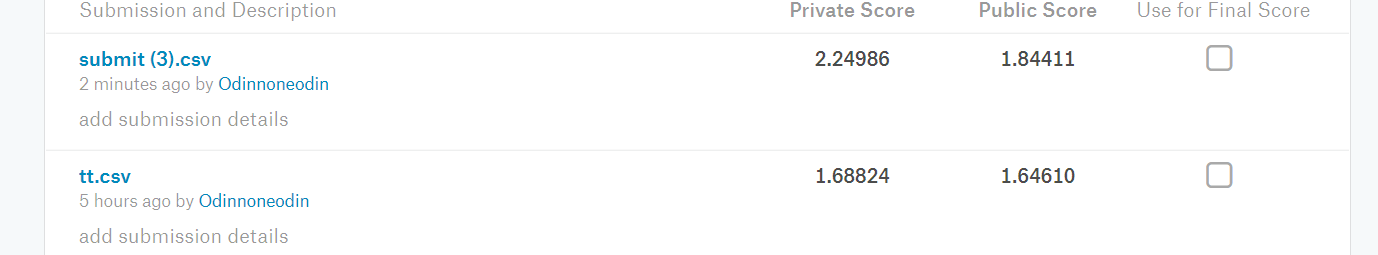